# Binary and multi class classification of images. 
CIFAR-10

## Binary classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as DT
import numpy.random as rd
import tensorflow.keras as keras
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve
from time import time
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
#load data (X1=Xtrain, y1=ytrain, X2=Xtest, y2=ytest)
cifar10=keras.datasets.cifar10
(X1,y1),(X2,y2)=cifar10.load_data()

#convert to grayscale (better results without conversion)
#X1 = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X1])
#X2 = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X2])

#binary labels (8=ship), *1 to convert it to a number
y1b=(y1==8)*1
y2b=(y2==8)*1

#reshape pixels into vector *1. to convert it to float
X1b=X1.reshape((50000,32*32*3))*1.
X2b=X2.reshape((10000,32*32*3))*1.

print(X1b.shape, X2b.shape, y1b.shape, y2b.shape)

#better results without unit variance, but takes longer time to classify
v=np.var(X1,axis=0)
thres=0#4000
idx=v<thres
print('Number of dimensions with variance less than %d:'%thres,np.sum(idx))

#zero mean (dosen't chage results significantly)
X1b=X1[:,~idx]/255
X2b=X2[:,~idx]/255
print(X1b.shape,X2b.shape)

#dosen't chage results significantly
sc=StandardScaler().fit(X1b)
X1c=sc.transform(X1b)
X2c=sc.transform(X2b)

(50000, 3072) (10000, 3072) (50000, 1) (10000, 1)
Number of dimensions with variance less than 0: 0
(50000, 3072) (10000, 3072)


In [3]:
#LinearSVC classifier
st=time()
svm=LinearSVC(C=1e-4, class_weight='balanced', random_state=1)
svm.fit(X1b,np.ravel(y1b))
y2be=svm.predict(X2b)
et=time()

print('Time (train/test): %.3f secs'%(et-st))
y2b=(np.transpose(y2b)).reshape(10000,)
CM=confusion_matrix(y2b,y2be)
print(CM)
print('Score:',np.sum(y2b==y2be)/y2b.shape[0]*100)
print('Number of erros:', np.sum(y2b!=y2be))

Time (train/test): 18.942 secs
[[6928 2072]
 [ 204  796]]
Score: 77.24
Number of erros: 2276


Text(0, 0.5, 'TP-rate')

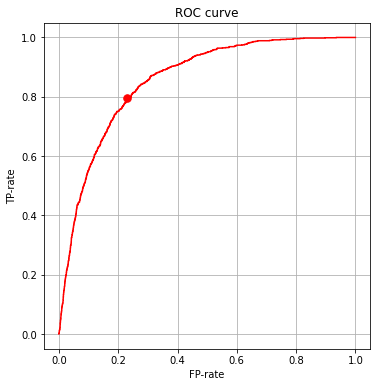

In [4]:
r2c=svm.decision_function(X2c)
fpr,tpr,t=roc_curve(y2b,r2c)

#Classificator
f=CM[0,1]/(CM[0,0]+CM[0,1])
#tp-rate=TP/(TP+FN)
r=CM[1,1]/(CM[1,1]+CM[1,0])

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot(f,r,'.r',ms=15)
plt.axis('scaled')
plt.grid(True)
plt.title('ROC curve')
plt.xlabel('FP-rate')
plt.ylabel('TP-rate')

In [13]:
#LinearSVC classifier with normalized data
st=time()
svm=LinearSVC(C=1e-4, class_weight='balanced', random_state=1)
svm.fit(X1c,np.ravel(y1b))
y2be=svm.predict(X2c)
et=time()

print('Time (train/test): %.3f secs'%(et-st))
y2b=(np.transpose(y2b)).reshape(10000,)
CM=confusion_matrix(y2b,y2be)
print(CM)
print('Score:',np.sum(y2b==y2be)/y2b.shape[0]*100)
print('Number of erros:', np.sum(y2b!=y2be))

Time (train/test): 7.024 secs
[[6880 2120]
 [ 192  808]]
Score: 76.88000000000001
Number of erros: 2312


With normalized data training is faster but results accuracy drops a litle bit. There are more correctly classfied boats image.

In [6]:
#Bagging classfier
st=time()
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging.fit(X1c,np.ravel(y1b))
y2be=bagging.predict(X2c)
et=time()
print('Time (train/test): %.3f secs'%(et-st))
y2b=(np.transpose(y2b)).reshape(10000,)
CM=confusion_matrix(y2b,y2be)
print(CM)
print('Score:',np.sum(y2b==y2be)/y2b.shape[0]*100)
print('Number of erros:', np.sum(y2b!=y2be))

Time (train/test): 7100.042 secs
[[8358  642]
 [ 411  589]]
Score: 89.47
Number of erros: 1053


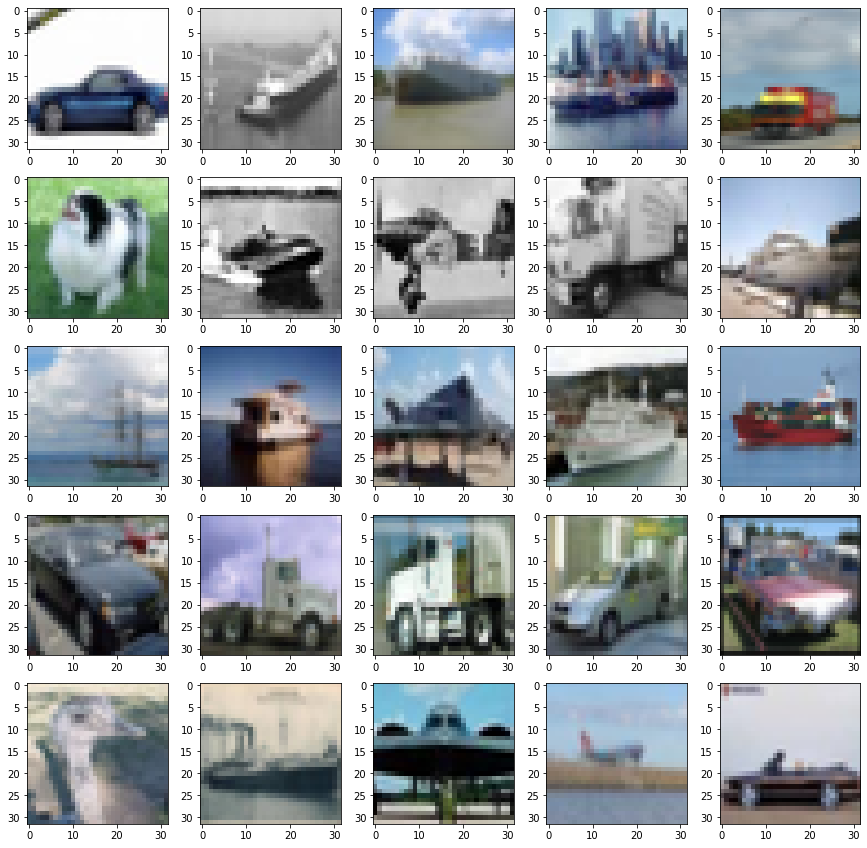

In [7]:
#check some images that are classified
j=100
plt.figure(figsize=(15,15)) 
for i in range(25):
    plt.subplot(5,5,i+1)    
    j+=1
    while(y2be[j]!=1):
        j+=1
    plt.imshow(X2[j])
plt.show()

Ther are quite a lot of errors.

Becouse data is inbalanced we are getting a lot of errors or small number of correctly clasified boats. So I will try to balance data for training, so I will take 5000 boats images and 5000 other images and use them for training and then check the results.

In [16]:
i=0
X1n=[]#all images except boat images
X1boat=[]#boat images
y1n=[]
y1boat=[]
#seperating boat images
for x in X1b:
    if(y1b[i]!=1):
        X1n.append(x)
        y1n.append(y1b[i])
    else:
        X1boat.append(x)
        y1boat.append(y1b[i])
    i+=1
X1n=np.array(X1n)
X1boat=np.array(X1boat)
y1n=np.array(y1n)
y1boat=np.array(y1boat)

#getting 5000 other images by performing train_test_split
X1s,X1sa,y1s,y1sa=train_test_split(X1n,y1n,train_size=5000)
#merging 5000 boat images with 5000 other images
X1boat=np.concatenate((X1boat, X1s), axis=0)
y1boat=np.concatenate((y1boat, y1s), axis=0)

In [17]:
#Random Forest Classifier training with balanced data.
st=time()
rfc = RandomForestClassifier(random_state=15,max_depth=25,n_estimators=250).fit(X1boat,np.ravel(y1boat))
y2be=rfc.predict(X2b)
et=time()

print('Time (train/test): %.3f secs'%(et-st))
y2b=(np.transpose(y2b)).reshape(10000,)
CM=confusion_matrix(y2b,y2be)
print(CM)
print('Score:',np.sum(y2b==y2be)/y2b.shape[0]*100)
print('Number of erros:', np.sum(y2b!=y2be))

Time (train/test): 91.676 secs
[[7612 1388]
 [ 194  806]]
Score: 84.17999999999999
Number of erros: 1582


Balancing data helped with keeping large amount of correctly classifed boat images and relativly high score

## Multi-class classification

In [22]:
#load data (X1=Xtrain, y1=ytrain, X2=Xtest, y2=ytest)
cifar10=keras.datasets.cifar10
(X1,y1),(X2,y2)=cifar10.load_data()

#convert to grayscale (better results without conversion)
#X1 = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X1])
#X2 = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X2])

#reshape pixels into vector *1. to convert it to float
X1b=X1.reshape((50000,32*32*3))*1.
X2b=X2.reshape((10000,32*32*3))*1.

print(X1b.shape, X2b.shape, y1.shape, y2.shape)

#better results without unit variance, but takes longer time to classify
v=np.var(X1,axis=0)
thres=0#4000
idx=v<thres
print('Number of dimensions with variance less than %d:'%thres,np.sum(idx))

#zero mean (dosen't chage results significantly)
X1b=X1[:,~idx]/255
X2b=X2[:,~idx]/255
print(X1b.shape,X2b.shape)

#dosen't chage results significantly
sc=StandardScaler().fit(X1b)
X1c=sc.transform(X1b)
X2c=sc.transform(X2b)


pca=PCA(n_components=350).fit(X1c)
X1p=pca.transform(X1c)
X2p=pca.transform(X2c)

(50000, 3072) (10000, 3072) (50000, 1) (10000, 1)
Number of dimensions with variance less than 0: 0
(50000, 3072) (10000, 3072)


array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

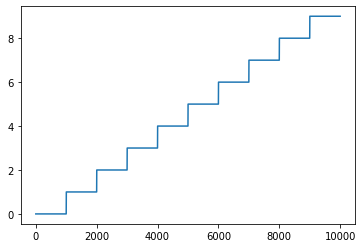

In [14]:
y2=np.reshape(y2, 10000)
idx=np.argsort(y2)
y2=y2[idx]
X2=X2[idx]
plt.plot(y2)
y2

Score: 48.209999999999994
Number of erros: 5179


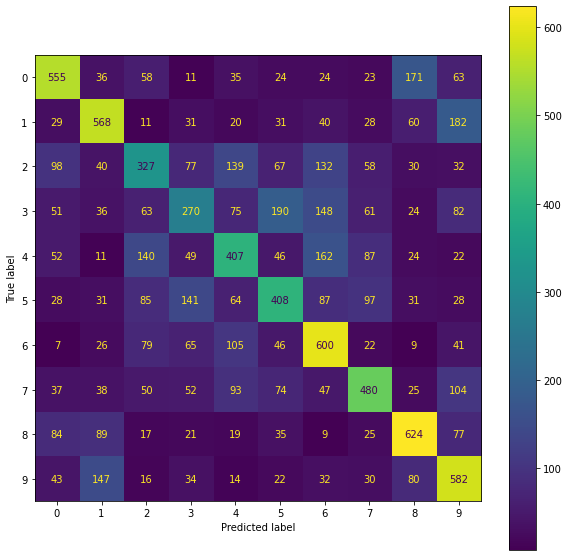

In [19]:
#Random Forest Classifier 
st=time()
rfc=RandomForestClassifier(random_state=42,max_depth=25,n_estimators=250).fit(X1b,np.ravel(y1))
y2e=rfc.predict(X2b)
et=time()

y2=(np.transpose(y2)).reshape(10000,)
print('Score:',np.sum(y2==y2e)/y2.shape[0]*100)
print('Number of erros:', np.sum(y2!=y2e))
_, ax = plt.subplots(figsize = (10, 10))
plt.rc('font', size=10)
ConfusionMatrixDisplay(confusion_matrix(y2,y2e), display_labels = list(range(10))).plot(ax = ax, values_format='')

We got 48% accuracy which is the better then using normalized data or PCA.

Score: 42.46
Number of erros: 5754


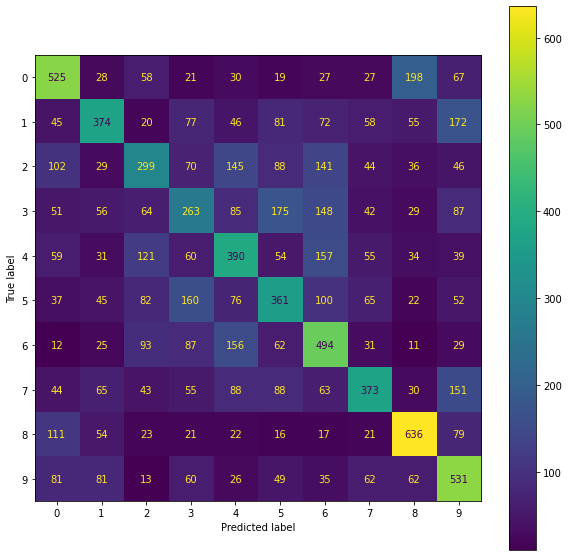

In [21]:
#Random Forest Classifier normalized data
st=time()
rfc=RandomForestClassifier(random_state=42,max_depth=25,n_estimators=250).fit(X1c,np.ravel(y1))
y2e=rfc.predict(X2c)
et=time()

y2=(np.transpose(y2)).reshape(10000,)
print('Score:',np.sum(y2==y2e)/y2.shape[0]*100)
print('Number of erros:', np.sum(y2!=y2e))
_, ax = plt.subplots(figsize = (10, 10))
plt.rc('font', size=10)
ConfusionMatrixDisplay(confusion_matrix(y2,y2e), display_labels = list(range(10))).plot(ax = ax, values_format='')

When useing normalized data we have worst results, probably becouse there is less data from which we can learn something.

Score: 46.7
Number of erros: 5330


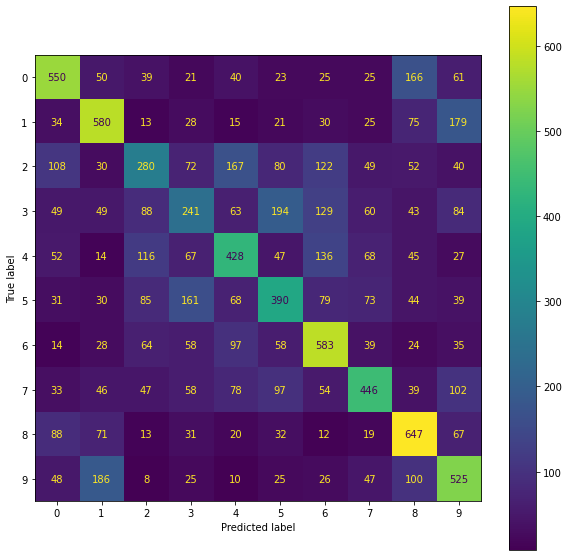

In [23]:
#Random Forest Classifier PCA
st=time()
rfc=RandomForestClassifier(random_state=42,max_depth=25,n_estimators=250).fit(X1p,np.ravel(y1))
y2e=rfc.predict(X2p)
et=time()

y2=(np.transpose(y2)).reshape(10000,)
print('Score:',np.sum(y2==y2e)/y2.shape[0]*100)
print('Number of erros:', np.sum(y2!=y2e))
_, ax = plt.subplots(figsize = (10, 10))
plt.rc('font', size=10)
ConfusionMatrixDisplay(confusion_matrix(y2,y2e), display_labels = list(range(10))).plot(ax = ax, values_format='')

With Random Forest Classifier PCA didn't help improve the results. 